In [46]:
import glob
import numpy as np

import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import colors
matplotlib.style.use('seaborn')

/tmp/ipykernel_3146603/1859864858.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


In [47]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def extrapolate(x, y, points=12000):
    # calculate polynomial
    z = np.polyfit(x, y, 5)
    f = np.poly1d(z)

    other_x = np.linspace(1, points, int(points/1))
    # other_y = f(other_x)
    other_y = np.interp(other_x, x, y)

    return other_x, other_y

def prepare_data(files, weight, points=12000):
    d = []
    for f in files:
        tmp = None
        if f.endswith('.csv'):
            tmp = csv_to_list(f)
            tmp[1] = smooth(tmp[1], weight)
            _x, _y = extrapolate(tmp[0], tmp[1], points)
            tmp = _y
        else:
            tmp = npy_to_list(f)
            tmp = smooth(tmp, weight)
        d.append(tmp)
    x = []
    if f.endswith('.csv'):
        x = _x
    else:
        x = np.linspace(0, 150.0*len(d[0]), len(d[0]))
    print(np.array(d).shape)
    y = np.average(d, axis=0)
    y_std = np.std(d, axis=0) 
    return x, y, y_std

def npy_to_list(filename):
    data = np.load(filename)
    data = np.sum(data, axis=3)
    data = data.reshape(-1)
    return data

def csv_to_list(filename):
    with open(filename, 'r') as f:
        csv_data = list(csv.reader(f, delimiter=","))
    l = np.array(csv_data[:], dtype=np.float64).T
    print(l.shape)
    return l

def numpy_ewma_vectorized(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha

    scale = 1/alpha_rev
    n = data.shape[0]

    r = np.arange(n)
    scale_arr = scale**r
    offset = data[0]*alpha_rev**(r+1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def smooth(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

def reformat_large_tick_values(tick_val, pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

In [57]:

def cumulative_reward_per_step(data, scale_factor=True):
    reward_details = np.array(data[:,2])
    total_rewards = [0]
    print('?', scale_factor)
    for episode_rewards in reward_details:
        for rw in episode_rewards:
            r = rw[0] + rw[1]
            if rw[2] < 0:
                r += -300
            if rw[3] > 10 or (not scale_factor and rw[0] > 0.68):
                r += 500
            # - step
            # if scale_factor:
            r -= 0.7
            total_rewards.append(total_rewards[-1]+r)

    return np.array(total_rewards)

def sum_reward_per_eps(rewards, cumulative=False):
    reward_per_eps = [0]
    total = 0
    for rw in rewards:
        if cumulative:
            if rw[-1] > -450 and rw[-1] < 450:
                total += np.sum(rw)
            if rw[-1] > 450:
                total += np.sum(rw[:-1]) + 10
            if rw[-1] < -450:
                total -= np.sum(rw[:-1]) - 10
            reward_per_eps.append(total)
        else:
            reward_per_eps.append(np.sum(rw))
    return reward_per_eps

def flatten(rewards):
    rewards_flattened = np.array([])
    for rw in rewards:
        rewards_flattened = np.append(rewards_flattened, rw)
    return rewards_flattened

def load_common_data(folder_names):
    combined_data = [load_data(folder) for folder in folder_names]
    return np.concatenate(combined_data)

def load_data(folder_name):
    filename = glob.glob(folder_name+'/state_*')
    if len(filename) > 0:
        return np.load(filename[0], allow_pickle=True)
    raise ValueError("File not found: %s" % (folder_name+'/state_*'))

def single_plot_detailed(folders, label='', color='C0', cumulative=False):
    all_data = []
    min_len = 10e8 
    for f in folders:
        scale = True if not 'Old' in label else False
        print(">?", not 'Old' in label, label)
        data =  cumulative_reward_per_step(load_data(f), scale)
        # data =  cumulative_reward_per_step(load_data(f)[:,1])
        all_data.append(data)
        if len(data) < min_len:
            min_len = len(data)

    all_data = np.array(all_data)

    for i in range(len(all_data)):
        all_data[i] = all_data[i][:min_len].flatten()

    print(all_data[0].shape, all_data[1].shape)

    all_data = np.stack((all_data[0], all_data[1]))
    y = np.average(all_data, axis=0)
    y_std = np.std(all_data, axis=0)
    # x = np.linspace(0, len(y), len(y))
    x = np.linspace(0, 100000, len(y))

    plt.plot(x, y, color=color,label=label)
    plt.fill_between(x, y-y_std, y+y_std, antialiased=True, linewidth=0.5, alpha=0.2, facecolor=color)
    # ax.plot(x, y, line_style, color=c, label=label, linewidth=linewidth)
    # ax.fill_between(x, y-y_std, y+y_std, antialiased=True, linewidth=0.5, alpha=alpha, edgecolor=c, facecolor=c)

def print_successful_episodes(data):
    rewards = np.array(data[:,1])
    reward_details = np.array(data[:,2])
    successes = 0
    for episode_rewards in reward_details:
        if episode_rewards[-1][3] > 0:
            successes += 1
        elif episode_rewards[-1][0] > 0.39:
            successes += 1
    print("num of successes", successes, 'out of', len(reward_details), '%', round(successes/len(reward_details),2))

def single_plot(data, label='', color='C0', cumulative=False, debug=False):
    obs = np.array(data[:,0])
    rewards = np.array(data[:,1])
    reward_details = np.array(data[:,2])
    print(label)
    print_successful_episodes(data)

    if debug:
        print(data.shape)
        print(np.array(obs[1]).shape)
        print(np.array(rewards[1]).shape)
        print(np.array(reward_details[1]).shape)

    rewards = np.delete(rewards, [0,1])

    rgb = colors.colorConverter.to_rgb(color)

    if cumulative:
        # y = np.array(sum_reward_per_eps(rewards, cumulative=True))
        # scale_factor = None
        # if 'rw' in label:
        #     if 'uniform' in label:
        #         scale_factor = np.load('/home/cambel/trufus/uniform_rw.npy')
        #     if 'normal' in label:
        #         scale_factor = np.load('/home/cambel/trufus/normal_rw.npy')
        y = cumulative_reward_per_step(data, False)
        # y = cumulative_reward_per_step(data[:,1], scale_factor)
        # y = np.log(y)
        x = np.linspace(0, len(y), len(y))
        print(len(y))
    else:
        y = np.array(sum_reward_per_eps(rewards))
        x = np.linspace(0, len(y), len(y))
        plt.plot(x,y,color=color, alpha=0.1)
        y = numpy_ewma_vectorized(np.array(sum_reward_per_eps(rewards)), 10)
    plt.plot(x,y,color=color,label=label)
    # plt.ylim(-450,450)

def multi_plot(folder_names, labels=None, cumulative=False):
    if not labels:
        labels = folder_names
    _colors = ['C0','C1','C2','C3','C4','C5','C6','C7']
    for i, folder in enumerate(folder_names):
        if isinstance(folder, list):
            single_plot_detailed(folder, label=labels[i], color=_colors[i], cumulative=cumulative)
        else:
            single_plot(load_data(folder), label=labels[i], color=_colors[i], cumulative=cumulative)


03
num of successes 910 out of 1395 % 0.65
? False
29995


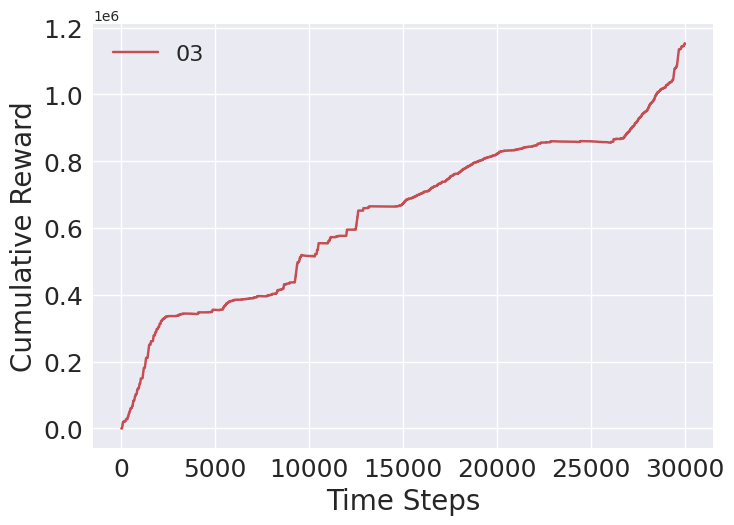

In [59]:
# single_plot(load_data("/root/o2ac-ur/results/interesting/01_SAC_slicing"), label="01", color='C0', cumulative=False)
# single_plot(load_data("/root/o2ac-ur/results/interesting/02_SAC_slicing"), label="02", color='C1', cumulative=False)
single_plot(load_data("/root/o2ac-ur/results/interesting/03_SAC_slicing"), label="03", color='C2', cumulative=True)
plt.xlabel('Time Steps', size=20)
plt.ylabel('Cumulative Reward', size=20)
# plt.ticklabel_format(style=('sci'), scilimits=(-5,3), useMathText=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=16)

01
num of successes 155 out of 316 % 0.49
? False
30197
02
num of successes 66 out of 173 % 0.38
? False
31802
03
num of successes 910 out of 1395 % 0.65
? False
29995


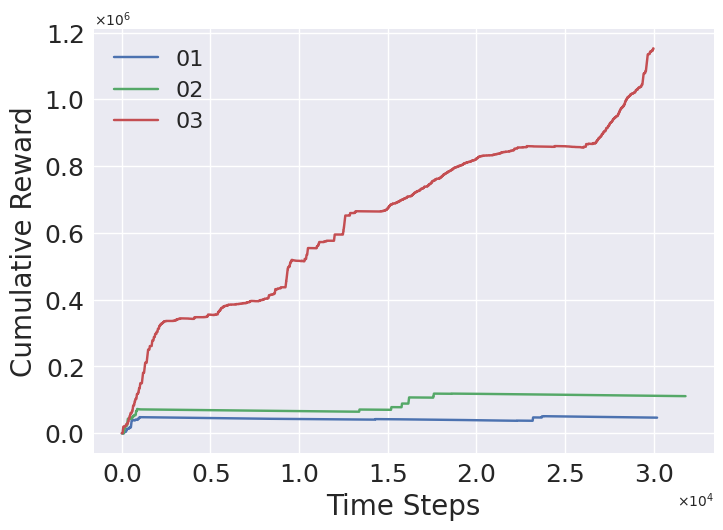

In [50]:
folders =[
"/root/o2ac-ur/results/interesting/01_SAC_slicing",
"/root/o2ac-ur/results/interesting/02_SAC_slicing",
"/root/o2ac-ur/results/interesting/03_SAC_slicing",
]
labels = ["01", "02", "03"]
multi_plot(folders, labels, cumulative=True)
plt.xlabel('Time Steps', size=20)
plt.ylabel('Cumulative Reward', size=20)
plt.ticklabel_format(style=('sci'), scilimits=(-5,3), useMathText=True)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='upper left', fontsize=16)